In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import PowerNorm
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable


from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models


:::{admonition} TIP
:class: hint
Enter Text here
:::

In [27]:
plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rc('legend',fontsize=15) # using a size in points


In [28]:
halo_masses = np.linspace(8,12,100) # just for the model

In [29]:
mass_example = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"]
red_example = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"]

mass_example = np.vstack(mass_example)
red_example = np.vstack(red_example)

In [30]:
N = 200

binH = np.linspace(8,12,N)
binS = np.linspace(2,10,N)

In [31]:
modelA = [10.5, 2.0, 0.15, 0, 0, 0]

modelB = [10.5, 2.0, 0.15, -0.1, 0, 0]

modelC = [10.5, 2.0, 0.15, 0, 0.1, 0]

model_label_A = "model A: [$\\alpha$="+str(modelA[1])+", $\\sigma_0$="+str(modelA[2])+", $\\gamma$="+str(modelA[3])+ ", $\\beta$="+str(modelA[4]) + "]"

model_label_B = "model B: [$\\alpha$="+str(modelB[1])+", $\\sigma_0$="+str(modelB[2])+", $\\gamma$="+str(modelB[3])+ ", $\\beta$="+str(modelB[4]) + "]"

model_label_C = "model C: [$\\alpha$="+str(modelC[1])+", $\\sigma_0$="+str(modelC[2])+", $\\gamma$="+str(modelC[3])+ ", $\\beta$="+str(modelC[4]) + "]"

### now adding the stats

In [32]:
def get_stats(lgMs, min_mass):
    min_mass = min_mass
    stat = jsm_stats.SatStats(lgMs)
    stat.Nsat(min_mass)
    stat.Maxmass()
    return stat

In [67]:
def multi_SHMR(theta_list, model_colors, model_labels, save_file=None):

    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), sharex='col', gridspec_kw={'width_ratios': [2, 1, 1]})

    for i, (ax, theta, model_color, model_label) in enumerate(zip(axs, theta_list, model_colors, model_labels)):
        stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
        theta_det = theta[:2] + [0, 0] + theta[4:]

        #### the first column ####

        if model_label != None:
            ax[0].set_title(model_label, fontsize=15, color=model_color)

        if i!=3:
            det = jsm_SHMR.general(theta_det, halo_masses, 0)
            ax[0].plot(halo_masses, det, color="black", label="deterministic", lw=2)

            sigma = theta[2] + theta[3] * (halo_masses - 12)
            sigma[sigma < 0] = 0.0

            ax[0].fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.6)
            ax[0].fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=model_color, alpha=0.4)
            ax[0].fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=model_color, alpha=0.2)

            SAGA_split = np.array_split(stellar_example, 100, axis=0)
            mock_lgMh, mock_lgMs = mass_example[0:100, :], SAGA_split[0]
            mass_cut = mock_lgMs > 6.5
            ax[0].scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
            ax[0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")
            
        else:
            z_max = 6
            z_array = np.arange(z_max+1)

            sigma = theta[2] + theta[3] * (halo_masses - 12)
            sigma[sigma < 0] = 0.0

            dethi = jsm_SHMR.general(theta_det, halo_masses, z_max)
            det0 = jsm_SHMR.general(theta_det, halo_masses, 0)

            ax[0].fill_between(halo_masses, det0 - sigma, dethi + sigma, color=model_color, alpha=0.6)
            ax[0].fill_between(halo_masses, det0 - 2 * sigma, dethi + 2 * sigma, color=model_color, alpha=0.4)
            ax[0].fill_between(halo_masses, det0 - 3 * sigma, dethi + 3 * sigma, color=model_color, alpha=0.2)

            cmap = plt.get_cmap('Reds_r')  # You can choose a different colormap
            colors = cmap(np.linspace(0, 1, z_array.shape[0]))
            custom_cmap = ListedColormap(colors)

            for i in z_array:   
                ax[0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
            
            norm = plt.Normalize(0, z_max)
            sm = ScalarMappable(cmap=custom_cmap, norm=norm)
            sm.set_array([])

            cax = ax[0].inset_axes([0.58, 0.3, 0.4, 0.04])
            colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
            colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
            colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

            SAGA_split = np.array_split(stellar_example, 100, axis=0)
            mock_lgMh, mock_lgMs = mass_example[0:100, :], SAGA_split[0]
            mass_cut = mock_lgMs > 6.5
            ax[0].scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
            ax[0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")

            ax[0].set_xlabel("M$_{\mathrm{acc}}$ [log (M$_\odot$)]", fontsize=15)
            ax[0].set_xlim(9.3, 12)

            ax[1].set_xlabel("N satellites", fontsize=15)
            ax[1].set_xlim(-0.5, 20)

            ax[2].set_xlabel("max( M$_{*}$ ) [log (M$_\odot$)]", fontsize=15)
            ax[2].set_ylabel("CDF", fontsize=15)

        if i == 0:
            ax[0].legend(fontsize=15)


        ax[0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)
        ax[0].set_ylim(6, 10)

        #### the second column ####

        stat_instance = get_stats(mock_lgMs, 6.5)
        ax[1].plot(np.arange(stat_instance.Pnsat.shape[0]), stat_instance.Pnsat, color="black", zorder=5)
        ax[1].set_ylabel("PDF", fontsize=15)
        ax[1].set_ylim(-0.01,0.4)

        #### the third column ####

        ax[2].plot(stat_instance.Msmax, stat_instance.ecdf_MsMax, color="black", zorder=5)
        ax[2].set_ylabel("CDF", fontsize=15)

        #### now for the permutations ####

        for mock in SAGA_split[1:99]:
            stat_instance_i = get_stats(mock, 6.5)
            ax[1].plot(np.arange(stat_instance_i.Pnsat.shape[0]), stat_instance_i.Pnsat, color=model_color, alpha=0.1, lw=1)
            ax[2].plot(stat_instance_i.Msmax, stat_instance_i.ecdf_MsMax, color=model_color, alpha=0.1, lw=1)

    plt.tight_layout()

    if save_file != None:
        plt.savefig(save_file, bbox_inches='tight')

    plt.show()

    #return stat_instance, mock_lgMh[mass_cut], mock_lgMs[mass_cut]


In [68]:
modelA = [10.5, 2.2, 0.15, 0, 0, 0]

modelB = [10.5       ,  1.99994749,  0.37445315,  0.13584481,  0.        ,
        0.        ] #[10.5, 2.0, 0.15, -0.15, 0, 0]

modelC = [10.5, 1.2, 0.2, 0, -0.45, 0]

modelD = [10.5, 2.2, 0.2, -0.05, 0.015, 1.2]

model_label_A = "model A: [$\\alpha$="+str(modelA[1])+", $\\sigma_0$="+str(modelA[2])+", $\\gamma$="+str(modelA[3])+ ", $\\beta$="+str(modelA[4]) + ", $\\tau$="+str(modelA[5]) + "]"
model_label_B = "model B: [$\\alpha$="+str(modelB[1])+", $\\sigma_0$="+str(modelB[2])+", $\\gamma$="+str(modelB[3])+ ", $\\beta$="+str(modelB[4]) + ", $\\tau$="+str(modelB[5]) + "]"
model_label_C = "model C: [$\\alpha$="+str(modelC[1])+", $\\sigma_0$="+str(modelC[2])+", $\\gamma$="+str(modelC[3])+ ", $\\beta$="+str(modelC[4]) + ", $\\tau$="+str(modelC[5]) + "]"
model_label_D = "model D: [$\\alpha$="+str(modelD[1])+", $\\sigma_0$="+str(modelD[2])+", $\\gamma$="+str(modelD[3])+ ", $\\beta$="+str(modelD[4]) + ", $\\tau$="+str(modelD[5]) + "]"

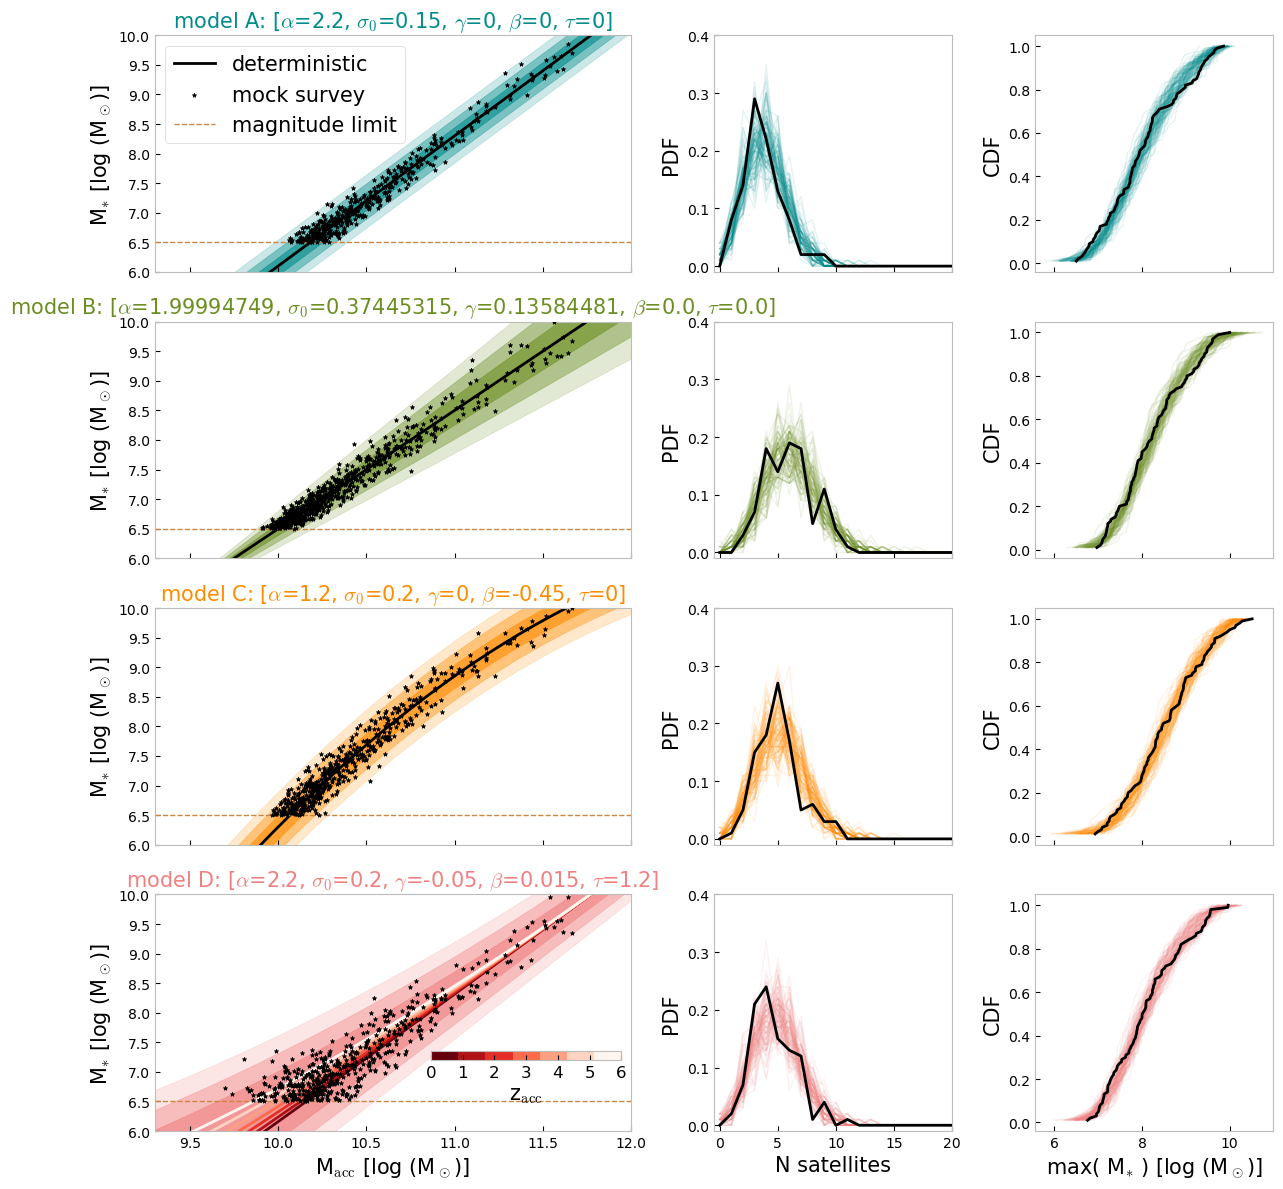

In [69]:
multi_SHMR(theta_list=[modelA, modelB, modelC, modelD], model_colors=["darkcyan", "olivedrab", "darkorange", 'lightcoral'], model_labels=[model_label_A, model_label_B, model_label_C, model_label_D])#, save_file="../../../paper_1/figures/SHMR.pdf")

In [70]:
modelA = [10.5, 2.2, 0.15, 0, 0, 0]

modelB = [10.5, 2.2, 0.35, 0, 0, 0]

modelC = [10.5, 2.2, 0.55, 0, 0, 0]

modelD = [10.5, 2.2, 0.75, 0, 0, 0]

model_label_A = "model A: [$\\alpha$="+str(modelA[1])+", $\\sigma_0$="+str(modelA[2])+", $\\gamma$="+str(modelA[3])+ ", $\\beta$="+str(modelA[4]) + ", $\\tau$="+str(modelA[5]) + "]"
model_label_B = "model B: [$\\alpha$="+str(modelB[1])+", $\\sigma_0$="+str(modelB[2])+", $\\gamma$="+str(modelB[3])+ ", $\\beta$="+str(modelB[4]) + ", $\\tau$="+str(modelB[5]) + "]"
model_label_C = "model C: [$\\alpha$="+str(modelC[1])+", $\\sigma_0$="+str(modelC[2])+", $\\gamma$="+str(modelC[3])+ ", $\\beta$="+str(modelC[4]) + ", $\\tau$="+str(modelC[5]) + "]"
model_label_D = "model D: [$\\alpha$="+str(modelD[1])+", $\\sigma_0$="+str(modelD[2])+", $\\gamma$="+str(modelD[3])+ ", $\\beta$="+str(modelD[4]) + ", $\\tau$="+str(modelD[5]) + "]"

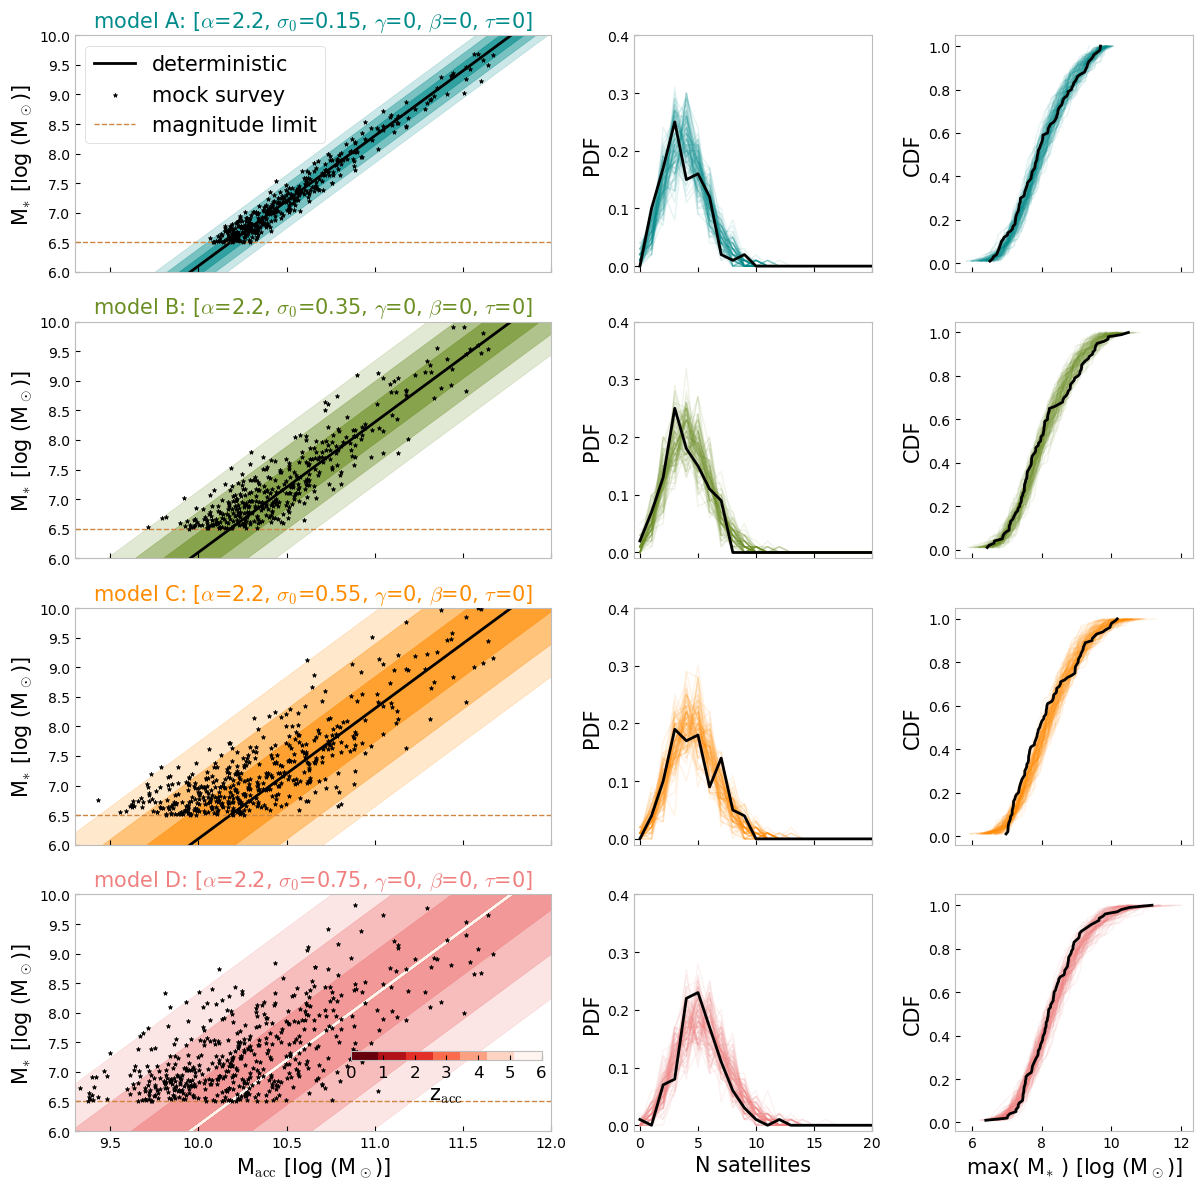

In [71]:
multi_SHMR(theta_list=[modelA, modelB, modelC, modelD], model_colors=["darkcyan", "olivedrab", "darkorange", 'lightcoral'], model_labels=[model_label_A, model_label_B, model_label_C, model_label_D])#, save_file="../../../paper_1/figures/SHMR.pdf")

In [72]:
modelA = [10.5, 2.2, 0.2, 0.1, 0, 0]

modelB = [10.5, 2.2, 0.2, 0.2, 0, 0]

modelC = [10.5, 2.2, 0.2, -0.1, 0, 0]

modelD = [10.5, 2.2, 0.2, -0.2, 0, 0]

model_label_A = "model A: [$\\alpha$="+str(modelA[1])+", $\\sigma_0$="+str(modelA[2])+", $\\gamma$="+str(modelA[3])+ ", $\\beta$="+str(modelA[4]) + ", $\\tau$="+str(modelA[5]) + "]"
model_label_B = "model B: [$\\alpha$="+str(modelB[1])+", $\\sigma_0$="+str(modelB[2])+", $\\gamma$="+str(modelB[3])+ ", $\\beta$="+str(modelB[4]) + ", $\\tau$="+str(modelB[5]) + "]"
model_label_C = "model C: [$\\alpha$="+str(modelC[1])+", $\\sigma_0$="+str(modelC[2])+", $\\gamma$="+str(modelC[3])+ ", $\\beta$="+str(modelC[4]) + ", $\\tau$="+str(modelC[5]) + "]"
model_label_D = "model D: [$\\alpha$="+str(modelD[1])+", $\\sigma_0$="+str(modelD[2])+", $\\gamma$="+str(modelD[3])+ ", $\\beta$="+str(modelD[4]) + ", $\\tau$="+str(modelD[5]) + "]"

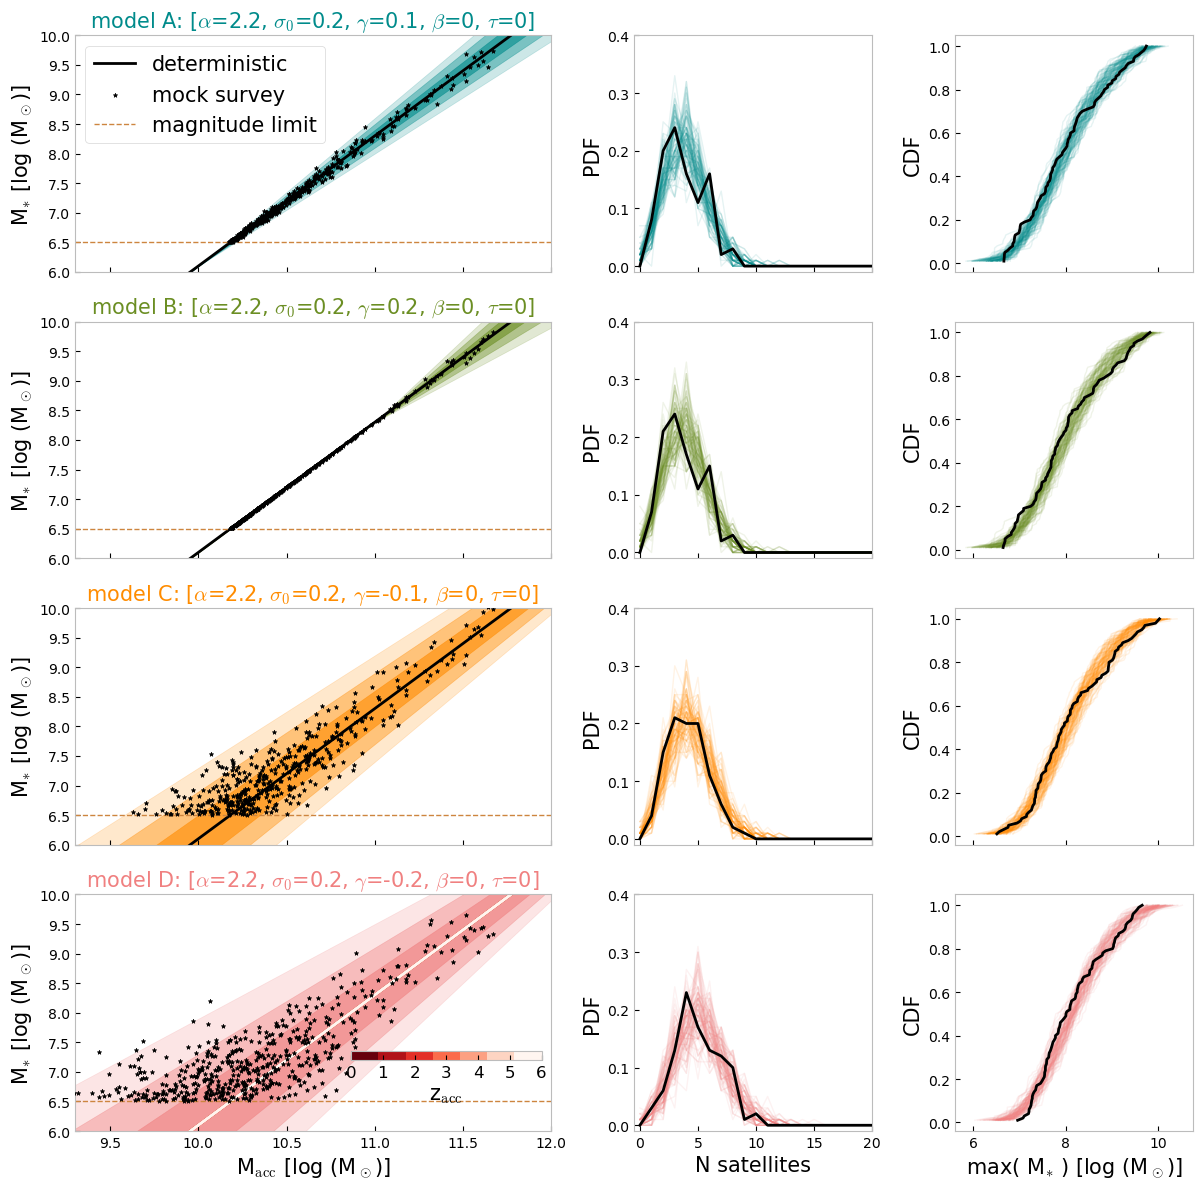

In [73]:
multi_SHMR(theta_list=[modelA, modelB, modelC, modelD], model_colors=["darkcyan", "olivedrab", "darkorange", 'lightcoral'], model_labels=[model_label_A, model_label_B, model_label_C, model_label_D])#, save_file="../../../paper_1/figures/SHMR.pdf")

In [74]:
modelA = [10.5, 2.0, 0.2, -0.05, 0, 0]

modelB = [10.5, 2.0, 0.2, -0.02, 0, 0]

modelC = [10.5, 2.0, 0.2, 0.02, 0, 0]

modelD = [10.5, 2.0, 0.2, 0.05, 0, 0]

model_label_A = "model A: [$\\alpha$="+str(modelA[1])+", $\\sigma_0$="+str(modelA[2])+", $\\gamma$="+str(modelA[3])+ ", $\\beta$="+str(modelA[4]) + ", $\\tau$="+str(modelA[5]) + "]"
model_label_B = "model B: [$\\alpha$="+str(modelB[1])+", $\\sigma_0$="+str(modelB[2])+", $\\gamma$="+str(modelB[3])+ ", $\\beta$="+str(modelB[4]) + ", $\\tau$="+str(modelB[5]) + "]"
model_label_C = "model C: [$\\alpha$="+str(modelC[1])+", $\\sigma_0$="+str(modelC[2])+", $\\gamma$="+str(modelC[3])+ ", $\\beta$="+str(modelC[4]) + ", $\\tau$="+str(modelC[5]) + "]"
model_label_D = "model D: [$\\alpha$="+str(modelD[1])+", $\\sigma_0$="+str(modelD[2])+", $\\gamma$="+str(modelD[3])+ ", $\\beta$="+str(modelD[4]) + ", $\\tau$="+str(modelD[5]) + "]"

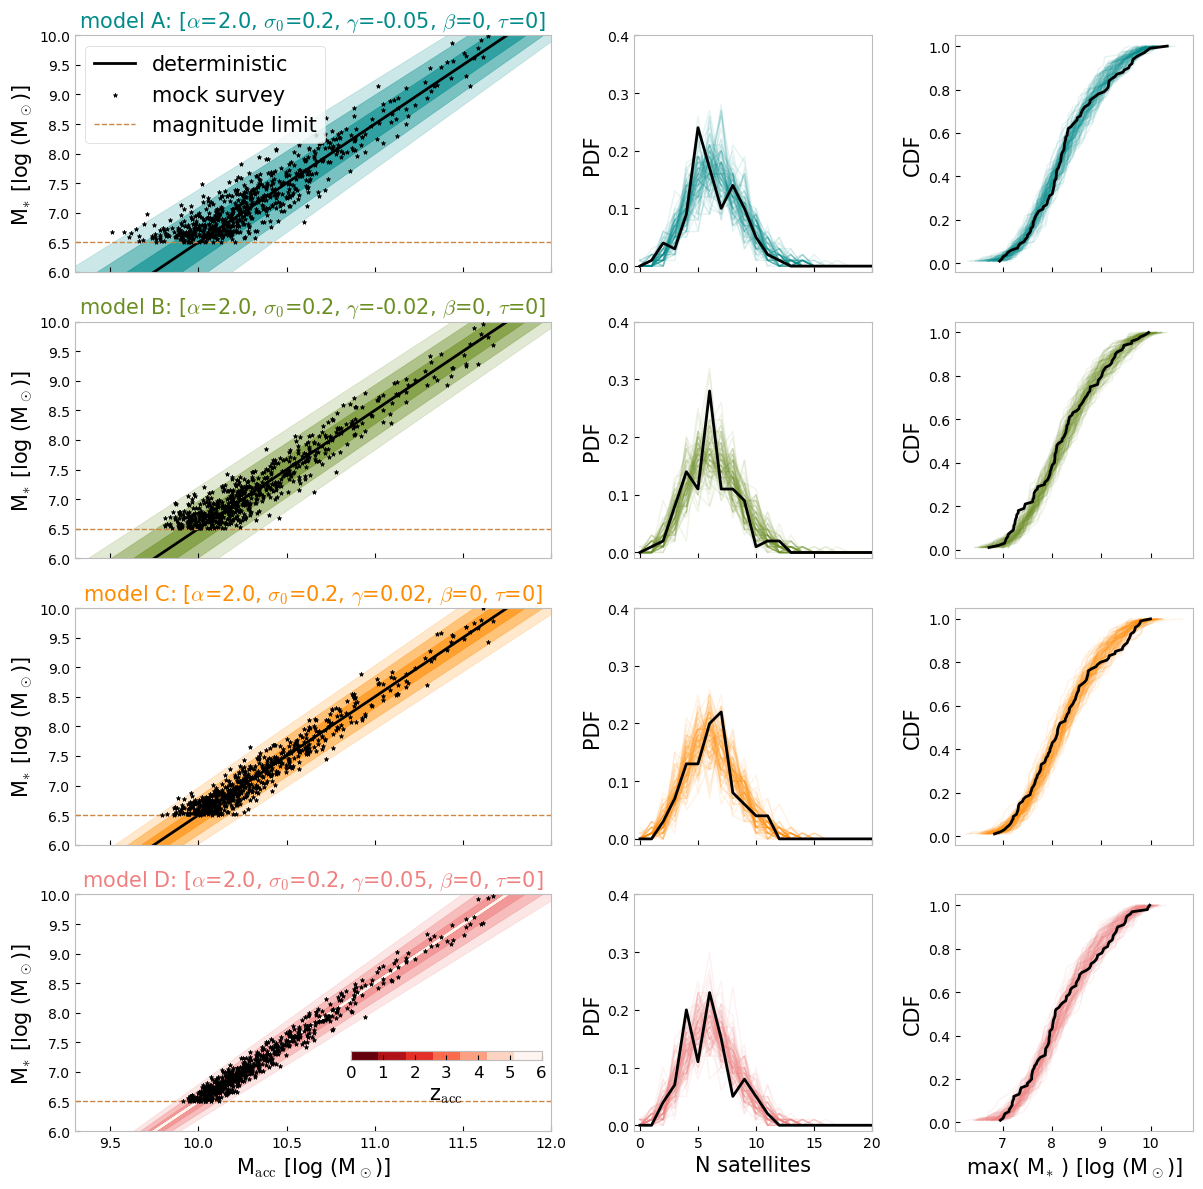

In [75]:
multi_SHMR(theta_list=[modelA, modelB, modelC, modelD], model_colors=["darkcyan", "olivedrab", "darkorange", 'lightcoral'], model_labels=[model_label_A, model_label_B, model_label_C, model_label_D])#, save_file="../../../paper_1/figures/SHMR.pdf")

In [76]:
modelA = [10.5, 2., 0.2, 0, 0.2, 0]

modelB = [10.5, 2., 0.2, 0, 0.1, 0]

modelC = [10.5, 2., 0.2, 0, -0.1, 0]

modelD = [10.5, 2., 0.2, 0, -0.2, 0]

model_label_A = "model A: [$\\alpha$="+str(modelA[1])+", $\\sigma_0$="+str(modelA[2])+", $\\gamma$="+str(modelA[3])+ ", $\\beta$="+str(modelA[4]) + ", $\\tau$="+str(modelA[5]) + "]"
model_label_B = "model B: [$\\alpha$="+str(modelB[1])+", $\\sigma_0$="+str(modelB[2])+", $\\gamma$="+str(modelB[3])+ ", $\\beta$="+str(modelB[4]) + ", $\\tau$="+str(modelB[5]) + "]"
model_label_C = "model C: [$\\alpha$="+str(modelC[1])+", $\\sigma_0$="+str(modelC[2])+", $\\gamma$="+str(modelC[3])+ ", $\\beta$="+str(modelC[4]) + ", $\\tau$="+str(modelC[5]) + "]"
model_label_D = "model D: [$\\alpha$="+str(modelD[1])+", $\\sigma_0$="+str(modelD[2])+", $\\gamma$="+str(modelD[3])+ ", $\\beta$="+str(modelD[4]) + ", $\\tau$="+str(modelD[5]) + "]"

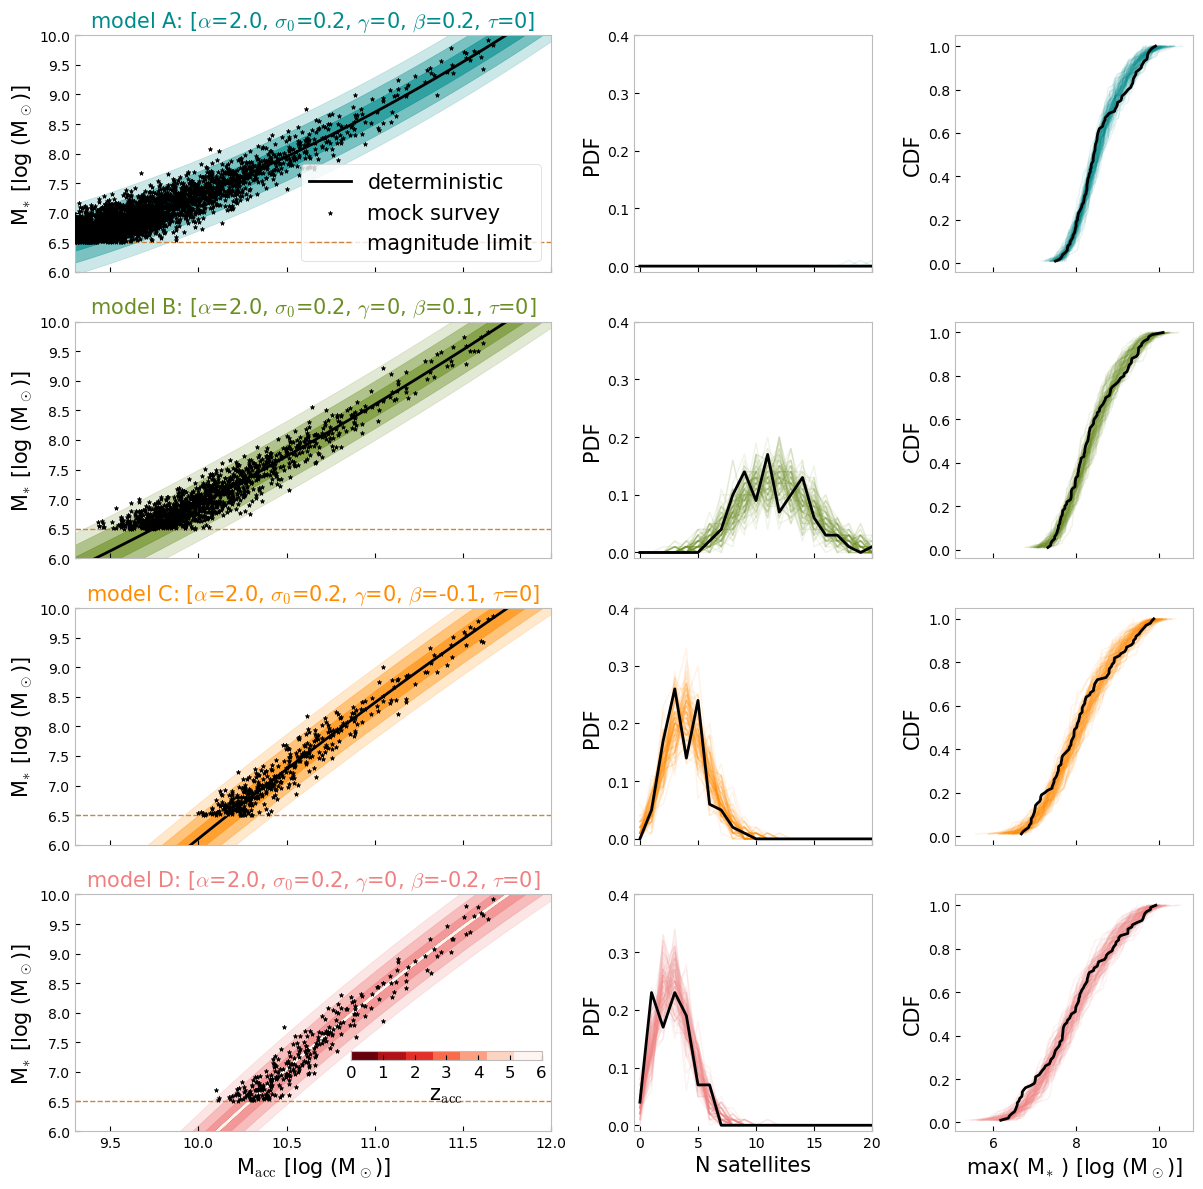

In [77]:
multi_SHMR(theta_list=[modelA, modelB, modelC, modelD], model_colors=["darkcyan", "olivedrab", "darkorange", 'lightcoral'], model_labels=[model_label_A, model_label_B, model_label_C, model_label_D])#, save_file="../../../paper_1/figures/SHMR.pdf")

#### now for the model instance

In [12]:
massdir = "/Users/jsmonzon/Research/data/MW-analog/meta_data_psi3/"

models = jsm_models.load_models(massdir, read_red=True) # need to change this for every run!

def forward(theta):
    models.convert_zacc(theta, jsm_SHMR.general)
    models.get_stats(min_mass=6.5)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

In [13]:
theta = [10.5, 2.0, 0.2, 0, 0, 0]
plabels = ["$M_{*}$", "$\\alpha$", "$\\sigma$"," $\\gamma$", "$\\beta$", "$\\tau$"]

In [14]:
models_alpha = jsm_mcmc.single_chain("../../mcmc/paper_runs/model_A/alpha/mock_1/chain.h5", Nstack=1, Nburn=2000, Nthin=10, truths=theta, labels=plabels)
model_label_A = "model A: [$\\alpha$="+str(theta[1])+", $\\sigma_0$="+str(theta[2])+", $\\gamma$="+str(theta[3])+ ", $\\beta$="+str(theta[4]) + ", $\\tau$="+str(theta[5]) + "]"


In [15]:
dataA = jsm_models.init_data(modelA, "../../mcmc/paper_runs/model_A/alpha/mock_1/mock_data.npy")

dataA.get_stats(min_mass=6.5, plot=False)
dataA.get_data_points(plot=False)

In [16]:
def model_SHMR(theta, data, models, model_color, model_label, save_file=None):

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharex='col', sharey='col', gridspec_kw={'width_ratios': [2, 1, 1]})

    stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
    theta_det = theta[:2] + [0, 0] + theta[4:]

    SAGA_split = np.array_split(stellar_example, 100, axis=0)
    mass_cut = data.lgMs > 6.5


    #### the 0,0 panel ####

    axs[0, 0].set_title(model_label, fontsize=15, color=model_color)

    det = jsm_SHMR.general(theta_det, halo_masses, 0)
    axs[0, 0].plot(halo_masses, det, color="black", label="deterministic", lw=2)
    axs[0, 0].scatter(data.lgMh[mass_cut], data.lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
    axs[0, 0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")
    axs[0, 0].legend(fontsize=12)
    axs[0, 0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)


    sigma = theta[2] + theta[3] * (halo_masses - 12)

    axs[0, 0].fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.6)
    axs[0, 0].fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=model_color, alpha=0.4)
    axs[0, 0].fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=model_color, alpha=0.2)
    axs[0, 0].set_ylim(6, 10)


    ### the 0,1 panel ###

    axs[0, 1].plot(np.arange(data.stat.Pnsat.shape[0]), data.stat.Pnsat, color="black", zorder=5)
    axs[0, 1].set_ylabel("PDF", fontsize=15)

    ### the 0,2 panel ###

    axs[0, 2].plot(data.stat.Msmax, data.stat.ecdf_MsMax, color="black", zorder=5)
    axs[0, 2].set_ylabel("CDF", fontsize=15)

    #### the 1,0 panel ####

    axs[1, 0].scatter(data.lgMh[mass_cut], data.lgMs[mass_cut], marker="*", color="black", s=10, zorder=5)
    axs[1, 0].axhline(6.5, ls="--", lw=1, color="peru")

    axs[1, 0].set_xlabel("M$_{\mathrm{acc}}$ [log (M$_\odot$)]", fontsize=15)
    axs[1, 0].set_xlim(9.3, 12)

    axs[1, 0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)
    axs[1, 0].set_ylim(6, 10)


    #### the 1,1 panel ####

    axs[1, 1].plot(np.arange(data.stat.Pnsat.shape[0]), data.stat.Pnsat, color="black", zorder=5)
    axs[1, 1].set_xlabel("N satellites", fontsize=15)
    axs[1, 1].set_ylabel("PDF", fontsize=15)
    axs[1, 1].set_xlim(-0.5, 20)
    axs[1, 1].set_ylim(-0.01,0.4)

    #### the 1,2 panel ####

    axs[1, 2].plot(data.stat.Msmax, data.stat.ecdf_MsMax, color="black", zorder=5)
    axs[1, 2].set_xlabel("max( M$_{*}$ ) [log (M$_\odot$)]", fontsize=15)
    axs[1, 2].set_ylabel("CDF", fontsize=15)
    #### the model iterations ####


    for k, theta in enumerate(models):
        theta_i = theta.tolist()
        hmm1, hmm2, hmm3 = forward(theta_i)
        axs[1, 1].plot(np.arange(hmm1.shape[0]), hmm1, color="grey", alpha=0.3, lw=1)
        axs[1, 2].plot(hmm2, hmm3, color="grey", alpha=0.3, lw=1)

        theta_det = theta_i[:2] + [0, 0] + theta_i[4:]
        if k==0:
            axs[1, 0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, 0), color="grey", label="model instances", alpha=0.3, lw=1)
        else:
            axs[1, 0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, 0), color="grey", alpha=0.3, lw=1)
        axs[1, 0].legend(fontsize=12)

    #### the data permutations ####

    for mock in SAGA_split[1:99]:
        stat_instance_i = get_stats(mock, 6.5)
        axs[0, 1].plot(np.arange(stat_instance_i.Pnsat.shape[0]), stat_instance_i.Pnsat, color=model_color, alpha=0.1, lw=1)
        axs[0, 2].plot(stat_instance_i.Msmax, stat_instance_i.ecdf_MsMax, color=model_color, alpha=0.1, lw=1)

    plt.tight_layout()

    if save_file != None:
        plt.savefig(save_file, bbox_inches='tight')
    
plt.show()




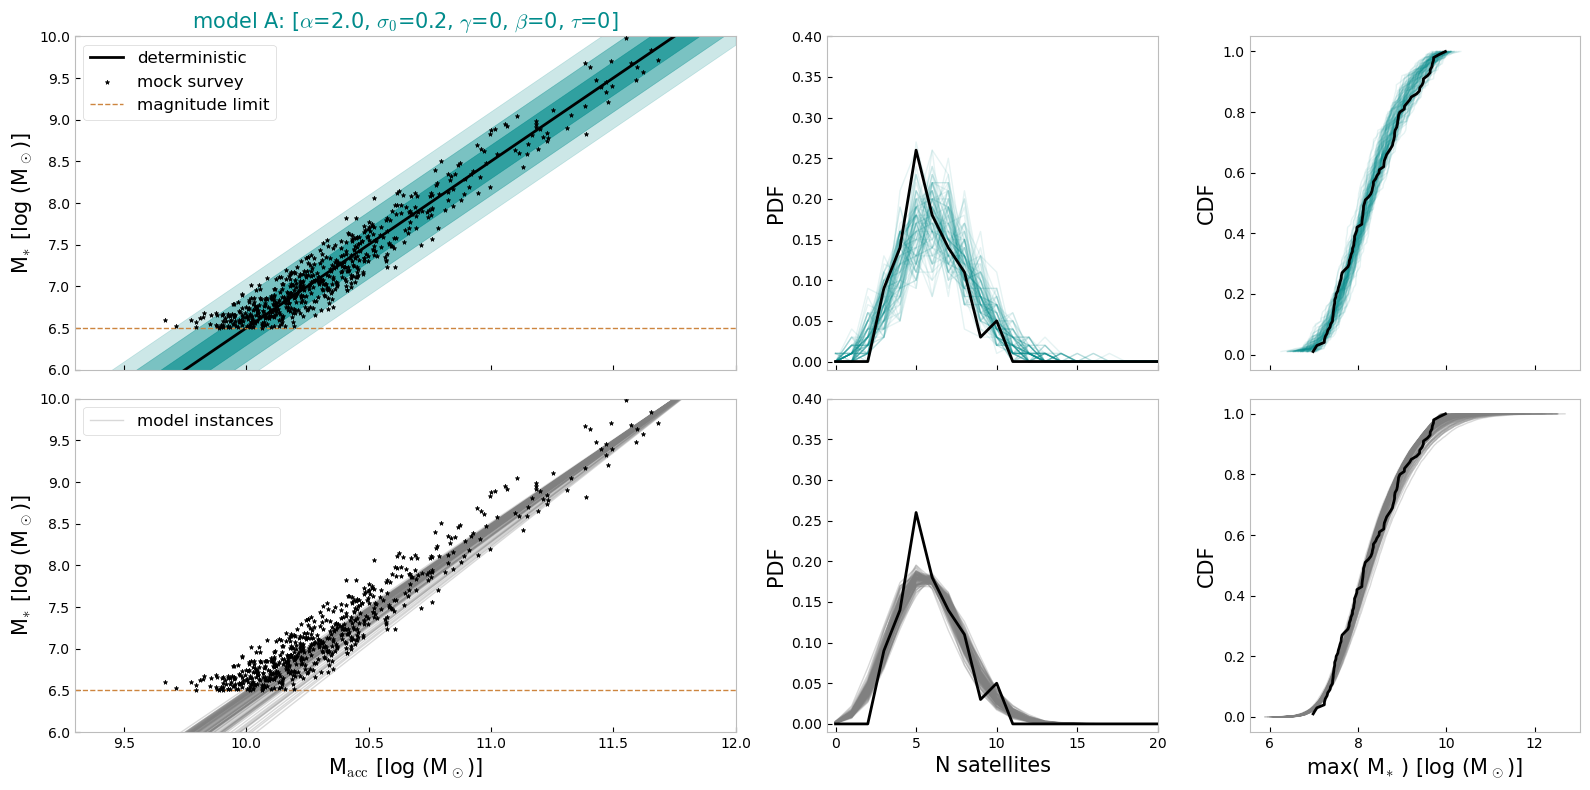

In [17]:
model_SHMR(theta, dataA, models_alpha.end, "darkcyan", model_label_A, save_file="../../../paper_1/figures/SHMR_model.pdf")

useful functions for plotting!

In [18]:
# def SHMR_PLOT(theta, model_label=None, mock=None, redshift=False, model_color="lightcoral", legend=False, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
#     theta_det = theta[:2] + [0, 0] + theta[4:]

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     fig, ax = plt.subplots(figsize=(8, 6))

#     # for i, Ms in enumerate(stellar_example):
#     #     plt.plot(mass_example[i], Ms, alpha=0.01, color="grey")

#     if model_label!=None:
#         ax.set_title(model_label, fontsize=15)

#     ax.axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")
#     ax.legend(fontsize=12)
#     ax.set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)

#     det8 = jsm_SHMR.general(theta_det, halo_masses, 8)
#     det0 = jsm_SHMR.general(theta_det, halo_masses, 0)

#     sigma = theta[2] + theta[3] * (halo_masses - 12)

#     ax.fill_between(halo_masses, det0 - sigma, det8 + sigma, color=model_color, alpha=0.6)
#     ax.fill_between(halo_masses, det0 - 2 * sigma, det8 + 2 * sigma, color=model_color, alpha=0.4)
#     ax.fill_between(halo_masses, det0 - 3 * sigma, det8 + 3 * sigma, color=model_color, alpha=0.2)

#     if redshift==True:
#         z_array = np.arange(9)

#         cmap = plt.get_cmap('Reds_r')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 8)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.25, 0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     if mock==True:
#         mock_index = np.random.randint(0,10000,100)
#         mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
#         mass_cut = mock_lgMs > 6.5
#         ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", s=9, color="black", label="Mock Survey", zorder=5)

#     ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlim(9.3, 12)
#     ax.set_ylim(6, 10)
#     if legend==True:
#         ax.legend(fontsize=15)

#     if save_file!=None:
#         ax.savefig(save_file)

#     plt.show()

In [19]:
# SHMR_PLOT([10.5, 1.9, 0.2, -0.05, 0.01, 1.2], redshift=True, mock=True)

In [20]:
# def plot_SHMR_dist(theta, theta_det, model_label, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     plt.figure(figsize=(8, 6))
#     plt.title(model_label, fontsize=15)
#     plt.hist2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS), norm=PowerNorm(gamma=0.15), cmap="Blues")
#     plt.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)
#     plt.ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     plt.xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     plt.yticks(fontsize=12)
#     plt.xticks(fontsize=12)
#     plt.grid(False)

#     plt.legend(fontsize=15)

#     if save_file !=None:
#         plt.savefig("../../SatGen/mcmc/figures/paper/"+save_file)
#     plt.show()
# def plot_contour(theta, theta_det, model_label, redshift=False, legend=False, save_file=None):

#     halo_masses = np.linspace(8,12,100) # just for the plotting

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     hist, xedges, yedges = np.histogram2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS))

#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.set_title(model_label, fontsize=15)

#     levels = np.linspace(0, hist.max(), 10)  # Adjust the number of levels as needed
#     contour = ax.contour(xedges[:-1], yedges[:-1], hist.T, [0.5], colors="cornflowerblue", label="scatter")
#     ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#     if redshift==True:
#         z_array = np.arange(10)

#         cmap = plt.get_cmap('plasma')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 9)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     plt.ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     plt.xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     plt.xlim(8, 11.7)
#     plt.ylim(2.3, 10.5)
#     if legend==True:
#         plt.legend(fontsize=15)

#     if save_file!=None:
#         plt.savefig(save_file)

#     plt.show()
# def SHMR_PLOT(theta, model_label=None, mock=None, redshift=False, hist2d=True, contour=True, comparison=False, legend=False, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
#     theta_det = theta[:2] + [0, 0] + theta[4:]

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     hist, xedges, yedges = np.histogram2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS))

#     fig, ax = plt.subplots(figsize=(8, 6))

#     for i, Ms in enumerate(stellar_example):
#         plt.plot(mass_example[i], Ms, alpha=0.01, color="grey")

#     if model_label!=None:
#         ax.set_title(model_label, fontsize=15)

#     if hist2d==True:
#         plt.hist2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS), cmap="Blues")

#     if contour==True:
#         levels = np.linspace(0, hist.max(), 10)  # Adjust the number of levels as needed
#         contour = ax.contour(xedges[:-1], yedges[:-1], hist.T, [0.5], colors="cornflowerblue", label="scatter")
        
#     if comparison==True:
#         ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#         ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#     ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)

#     if redshift==True:
#         z_array = np.arange(10)

#         cmap = plt.get_cmap('plasma')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 9)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     if mock==True:
#         mock_index = np.random.randint(0,10000,100)
#         mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
#         mass_cut = mock_lgMs > 6.5
#         ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", s=9, color="black", label="Mock Survey")

#     ax.set_ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlim(8, 11.7)
#     ax.set_ylim(4, 10)
#     if legend==True:
#         ax.legend(fontsize=15)

#     if save_file!=None:
#         ax.savefig(save_file)

#     plt.show()
# def new_SHMR(theta, model_color, model_label=None, mock=True, redshift=False, comparison=False, legend=False, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
#     theta_det = theta[:2] + [0, 0] + theta[4:]

#     fig, ax = plt.subplots(figsize=(8, 6))

#     if model_label!=None:
#         ax.set_title(model_label, fontsize=15)

#     if comparison==True:
#         ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#         ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#     det = jsm_SHMR.general(theta_det, halo_masses, 0)
#     ax.plot(halo_masses, det, color=model_color, label="determinisitic", lw=2)

#     sigma = theta[2] + theta[3]*(halo_masses-12)
    
#     ax.fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.5) 
#     ax.fill_between(halo_masses, det - 2*sigma, det + 2*sigma, color=model_color, alpha=0.3) 
#     ax.fill_between(halo_masses, det - 3*sigma, det + 3*sigma, color=model_color, alpha=0.1) 

#     if redshift==True:
#         z_array = np.arange(10)

#         cmap = plt.get_cmap('viridis')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 9)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     if mock==True:
#         mock_index = np.random.randint(0,10000,100)
#         mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
#         mass_cut = mock_lgMs > 6.5
#         ax.axhline(6.5, ls="--", label="magnitude limit", lw=1, color="grey")
#         ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", zorder=5)

#     ax.set_ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlim(8.5, 11.8)
#     ax.set_ylim(5.5, 10)
#     if legend==True:
#         ax.legend(fontsize=15)

#     if save_file!=None:
#         ax.savefig(save_file)

#     plt.show()
# theta = [10.5, 1.9, 0.2, 0, 0, 0]

# new_SHMR(theta, model_label="test", model_color="olivedrab", mock=True, legend=True)
### new figures for the paper
# def multi_SHMR(theta_list, model_colors, model_labels, mock=True, comparison=False, save_file=None):

#     fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 15), sharey=True, sharex=True)

#     for i, (ax, theta, model_color, model_label) in enumerate(zip(axs, theta_list, model_colors, model_labels)):
#         stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
#         theta_det = theta[:2] + [0, 0] + theta[4:]

#         if model_label != None:
#             ax.set_title(model_label, fontsize=15, color=model_color)

#         if comparison == True:
#             ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#             ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#         det = jsm_SHMR.general(theta_det, halo_masses, 0)
#         ax.plot(halo_masses, det, color="black", label="deterministic", lw=2)

#         sigma = theta[2] + theta[3] * (halo_masses - 12)

#         ax.fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.5)
#         ax.fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=model_color, alpha=0.3)
#         ax.fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=model_color, alpha=0.1)

#         if mock == True:
#             mock_index = np.random.randint(0, 10000, 100)
#             mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
#             mass_cut = mock_lgMs > 6.5
#             ax.axhline(6.5, ls="--", label="magnitude limit", lw=1, color="grey")
#             ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", s=20, zorder=5)

#         if i == 2:
#             ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#             ax.set_xlim(9.3, 12)
#         if i == 0:
#             ax.legend(fontsize=15)


#         ax.set_ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#         ax.set_ylim(6, 10)

#     plt.tight_layout()

#     if save_file != None:
#         plt.savefig(save_file)

#     plt.show()


# def plot_twostat(data, modelz, model_label, save_file=None, model=None):

#     fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1, 1]})
#     axs[0].set_title(model_label, fontsize=15, color="darkcyan")

#     mass_cut = data.lgMs > 6.5

#     axs[0].scatter(data.lgMh[mass_cut], data.lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
#     axs[0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="grey")
#     axs[0].set_ylim(6, 10)
#     axs[0].set_xlim(9.3, 12)

#     axs[0].set_xlabel("M$_{\mathrm{acc}}$ [log (M$_\odot$)]", fontsize=15)
#     axs[0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)
#     axs[0].legend(fontsize=12)


#     # Plot the first graph on the left subplot

#     for theta in modelz:
#         theta_i = theta.tolist()
#         hmm1, hmm2, hmm3 = forward(theta_i)
#         axs[1].plot(np.arange(hmm1.shape[0]), hmm1, color="grey", alpha=0.3, lw=1)
#         axs[2].plot(hmm2, hmm3, color="grey", alpha=0.3, lw=1)

#         theta_det = theta_i[:2] + [0, 0] + theta_i[4:]
#         axs[0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, 0), color="grey", alpha=0.3, lw=1)

#     axs[1].set_xlabel("N satellites", fontsize=15)
#     axs[1].set_ylabel("PDF", fontsize=15)
#     axs[1].set_xlim(0, 25)
#     axs[1].set_ylim(-0.01,0.35)

#     # Plot the second graph on the right subplot

#     axs[1].plot(np.arange(data.stat.Pnsat.shape[0]), data.stat.Pnsat, color="black", zorder=5)
#     axs[2].plot(data.stat.Msmax, data.stat.ecdf_MsMax, color="black", zorder=5)


#     axs[2].set_xlabel("max( M$_{*}$ ) [log (M$_\odot$)]", fontsize=15)
#     axs[2].set_ylabel("CDF", fontsize=15)

#     # Adjust layout to prevent clipping of labels
#     plt.tight_layout()
#     # Show the plot

#     if save_file !=None:
#         plt.savefig(save_file, bbox_inches="tight")

#     plt.show()